In [2]:
import torch
from transformers import TableTransformerForObjectDetection
from torchvision import transforms
from PIL import Image
from PIL import ImageDraw
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm
import pandas as pd


C:\Users\kavin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:


# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

In [5]:
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

In [6]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
     

In [53]:
table_region = Image.open("table_region.png")

In [54]:

pixel_values = structure_transform(table_region).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 662, 1000])


In [55]:
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [10]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


In [11]:
def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})
    
    return objects


In [56]:
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, table_region.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9999949932098389, 'bbox': [1259.590576171875, 115.4565200805664, 3984.348388671875, 4502.0966796875]}, {'label': 'table row', 'score': 0.9999597072601318, 'bbox': [74.62223052978516, 1562.3397216796875, 6878.74853515625, 2074.653076171875]}, {'label': 'table column', 'score': 0.999982476234436, 'bbox': [5381.24755859375, 113.1720199584961, 6001.26513671875, 4499.896484375]}, {'label': 'table column', 'score': 0.9999068975448608, 'bbox': [3993.168212890625, 111.93744659423828, 4691.4208984375, 4498.39892578125]}, {'label': 'table column', 'score': 0.9999842643737793, 'bbox': [4700.90625, 112.11357879638672, 5371.61279296875, 4500.197265625]}, {'label': 'table row', 'score': 0.9999624490737915, 'bbox': [75.22737121582031, 532.6163330078125, 6876.740234375, 1050.515625]}, {'label': 'table column', 'score': 0.9999743700027466, 'bbox': [6006.31005859375, 114.0467758178711, 6879.794921875, 4499.82421875]}, {'label': 'table column header', 'score': 0.9992

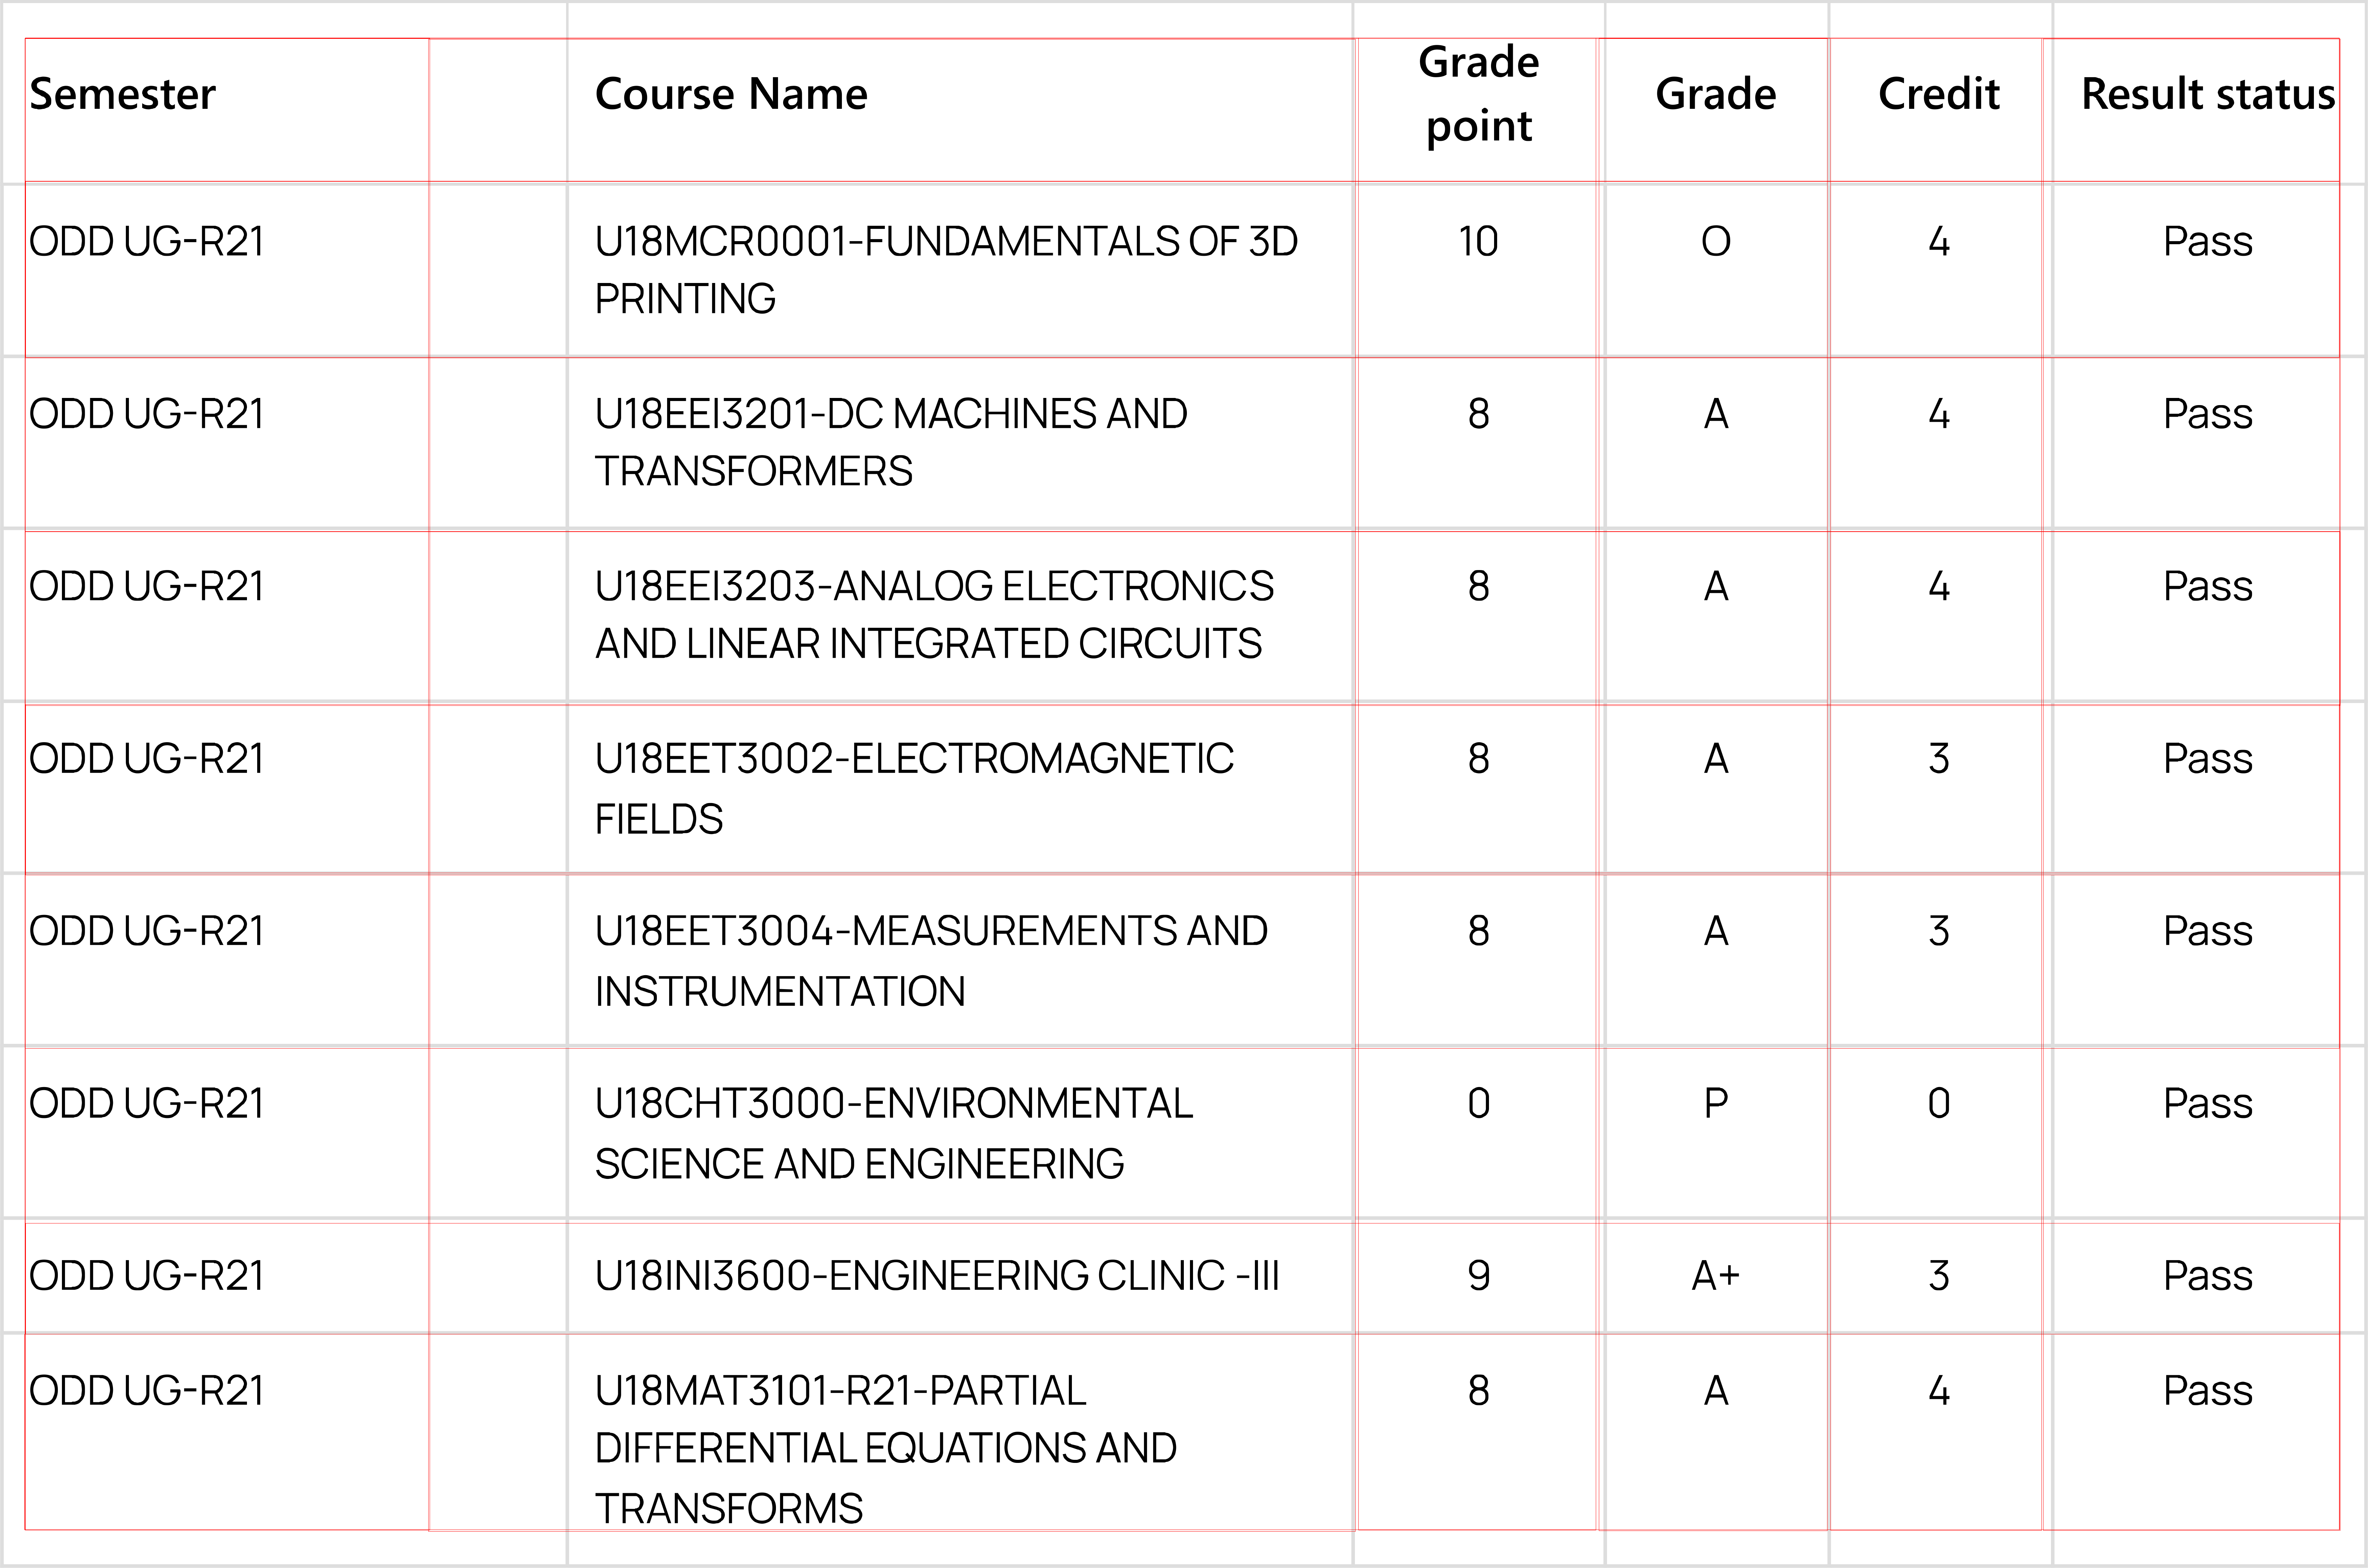

In [57]:
cropped_table_visualized = table_region.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [58]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [27]:
len(cell_coordinates)

9

In [28]:
len(cell_coordinates[0]["cells"])

6

In [59]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [73.861083984375, 112.83335876464844, 1263.7864990234375, 4498.53564453125], 'cell': [73.861083984375, 111.78327941894531, 1263.7864990234375, 532.4595336914062]}, {'column': [1259.590576171875, 115.4565200805664, 3984.348388671875, 4502.0966796875], 'cell': [1259.590576171875, 111.78327941894531, 3984.348388671875, 532.4595336914062]}, {'column': [3993.168212890625, 111.93744659423828, 4691.4208984375, 4498.39892578125], 'cell': [3993.168212890625, 111.78327941894531, 4691.4208984375, 532.4595336914062]}, {'column': [4700.90625, 112.11357879638672, 5371.61279296875, 4500.197265625], 'cell': [4700.90625, 111.78327941894531, 5371.61279296875, 532.4595336914062]}, {'column': [5381.24755859375, 113.1720199584961, 6001.26513671875, 4499.896484375], 'cell': [5381.24755859375, 111.78327941894531, 6001.26513671875, 532.4595336914062]}, {'column': [6006.31005859375, 114.0467758178711, 6879.794921875, 4499.82421875], 'cell': [6006.31005859375, 111.78327941894531, 6879.794921875, 532

In [60]:
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(table_region.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
100%|██████████| 9/9 [02:53<00:00, 19.33s/it]

Max number of columns: 6
['Semester', 'Course Name', 'Grade point', 'Grade', 'Credit', 'Result status']
['ODD UG-R2I', 'U18MCROOOI-FUNDAMENTALS OF 3D PRINTING', '10', '0', 'Pass', '']
['ODD UG-R21', 'UI8EEI3201-DC MACHINES AND TRANSFORMERS', '8', 'A', 'Pass', '']
['ODD UG-R2I', 'UI8EEI3203-ANALOG ELECTRONICS AND LINEAR INTEGRATED CIRCUITS', '8', 'A', 'Pass', '']
['ODD UG-R21', 'UI8EET3002-ELECTROMAGNETIC FIELDS', '8', 'A', '3', 'Pass']
['ODD UG-R2I', 'UI8EET3OO4-MEASUREMENTS AND INSTRUMENTATION', '8', 'A', '3', 'Pass']
['ODD UG-R2I', 'UI8CHT3OOO-ENVIRONMENTAL SCIENCE AND ENGINEERING', '0', 'P', '0', 'Pass']
['ODD UG-R2I', 'U18INI3600-ENGINEERING CLINIC -III', '9', 'A+', '3', 'Pass']
['ODD UG-R21', 'UI8MAT3101-R2I-PARTIAL DIFFERENTIALEQUATIONS AND TRANSFORMS', '8', 'A', 'Pass', '']


In [61]:
with open('output.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data.items():
      wr.writerow(row_text)

In [62]:
df = pd.read_csv("output.csv")
df.head()
     

,Semester,Course Name,Grade point,Grade,Credit,Result status
0,ODD UG-R2I,U18MCROOOI-FUNDAMENTALS OF 3D PRINTING,10,0,Pass,NaN
1,ODD UG-R21,UI8EEI3201-DC MACHINES AND TRANSFORMERS,8,A,Pass,NaN
2,ODD UG-R2I,UI8EEI3203-ANALOG ELECTRONICS AND LINEAR INTEG...,8,A,Pass,NaN
3,ODD UG-R21,UI8EET3002-ELECTROMAGNETIC FIELDS,8,A,3,Pass
4,ODD UG-R2I,UI8EET3OO4-MEASUREMENTS AND INSTRUMENTATION,8,A,3,Pass
